In [37]:
import os
import numpy as np
import nibabel as nib
from PIL import Image
import random
from tqdm import tqdm

In [38]:
def load_nii(file_path):
    """Load a NIfTI file and return the numpy array and affine."""
    nii = nib.load(file_path)
    return nii.get_fdata(), nii.affine


In [39]:
def trim_volume(volume, trim_percentages):
    """
    Trim percentages off both ends along x, y, z axes.
    trim_percentages: tuple of percentages (x%, y%, z%) as decimals.
    """
    trimmed = volume.copy()
    for axis, perc in enumerate(trim_percentages):
        trim_size = int(trimmed.shape[axis] * perc)
        indices = list(range(trim_size, trimmed.shape[axis] - trim_size))
        trimmed = np.take(trimmed, indices, axis=axis)
    return trimmed

In [40]:
def sample_indices(num_slices, t, flatten=True):
    """
    Sample indices along one axis with a distribution that covers edges.
    If flatten=True, use a wide, flat-ish distribution (normal + clipped tails).
    """
    num_samples = max(1, int(num_slices * t))
    if flatten:
        indices = np.random.normal(loc=num_slices/2, scale=num_slices/3, size=num_samples*2).astype(int)
        indices = np.clip(indices, 0, num_slices-1)
        indices = np.unique(indices)
        if len(indices) > num_samples:
            indices = np.random.choice(indices, size=num_samples, replace=False)
    else:
        indices = np.random.normal(loc=num_slices/2, scale=num_slices/6, size=num_samples).astype(int)
        indices = np.clip(indices, 0, num_slices-1)
        indices = np.unique(indices)
    return np.sort(indices)

In [41]:
def sample_slices_all_planes_reference(volume, t=0.1, flatten=True):
    """
    Sample slices along all three planes (x, y, z) for reference.
    Returns a list of tuples: (plane, idx)
    """
    planes = ['sagittal', 'coronal', 'axial']
    sampled_indices_per_plane = []
    for axis, plane in enumerate(planes):
        num_slices = volume.shape[axis]
        indices = sample_indices(num_slices, t, flatten)
        sampled_indices_per_plane.extend([(plane, idx) for idx in indices])
    return sampled_indices_per_plane


In [42]:
def normalize_to_uint8(slice_data):
    """Normalize a numpy 2D array to uint8 (0–255)."""
    min_val, max_val = np.min(slice_data), np.max(slice_data)
    if max_val == min_val:
        return np.zeros_like(slice_data, dtype=np.uint8)
    norm = (slice_data - min_val) / (max_val - min_val)
    return (norm * 255).astype(np.uint8)


In [43]:
def seg_to_gray(slice_data):
    """Convert segmentation with 3 classes to grayscale mapping."""
    mapping = {0: 0, 1: 85, 2: 170, 4: 255}  # adjust if you have only 3 classes (0,1,2)
    out = np.zeros_like(slice_data, dtype=np.uint8)
    for k, v in mapping.items():
        out[slice_data == k] = v
    return out


In [44]:
def save_slices(sampled_slices, out_dir, case_name, modality, is_seg=False):
    """
    Save sampled slices into grayscale PNGs under out_dir/modality.
    """
    os.makedirs(out_dir, exist_ok=True)
    for plane, idx, slice_2d in sampled_slices:
        if is_seg:
            img_array = seg_to_gray(slice_2d)
        else:
            img_array = normalize_to_uint8(slice_2d)
        img = Image.fromarray(img_array, mode='L')
        filename = f"{case_name}_{modality}_{plane}_{idx}.png"
        img.save(os.path.join(out_dir, filename))

In [45]:
def process_all_cases(root_dir, out_root="sampled_pngs", trim_perc=(0.24,0.24,0.11), t=0.1, flatten=True):
    """
    Process all patients: load, trim, sample (all planes), and save slices.
    """
def process_all_cases(root_dir, out_root="sampled_pngs", trim_perc=(0.24,0.24,0.11), t=0.1, flatten=True):
    """
    Process all patients: load, trim, sample (all planes), and save slices.
    Slices are aligned across all modalities.
    """
    os.makedirs(out_root, exist_ok=True)
    case_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir)
                 if os.path.isdir(os.path.join(root_dir, d))]

    for case_dir in tqdm(case_dirs, desc="Processing patients"):
        case_name = os.path.basename(case_dir)
        files = {
            'flair': (f"{case_name}_flair.nii", False),
            't1ce':  (f"{case_name}_t1ce.nii", False),
            'seg':   (f"{case_name}_seg.nii", True)
        }

        # Load and trim all modalities
        vols = {}
        for modality, (fname, is_seg) in files.items():
            path = os.path.join(case_dir, fname)
            if not os.path.exists(path):
                print(f"[WARNING] Missing: {path}")
                continue
            vol, _ = load_nii(path)
            vols[modality] = trim_volume(vol, trim_perc)

        if not vols:
            print(f"[WARNING] No volumes for {case_name}, skipping...")
            continue

        # Sample slices once using first modality as reference
        first_modality = list(vols.keys())[0]
        sampled_indices_per_plane = sample_slices_all_planes_reference(vols[first_modality], t, flatten)

        # Apply same indices to all modalities
        for modality, vol in vols.items():
            sampled_slices = []
            for plane, idx in sampled_indices_per_plane:
                axis = {'sagittal': 0, 'coronal': 1, 'axial': 2}[plane]
                slice_2d = np.take(vol, idx, axis=axis)
                sampled_slices.append((plane, idx, slice_2d))
            modality_out_dir = os.path.join(out_root, modality)
            save_slices(sampled_slices, modality_out_dir, case_name, modality,
                        is_seg=(modality=='seg'))


    print("[INFO] All cases processed.")

In [46]:
base_root = r"..\data\MICCAI_BraTS2020_TrainingData"
output_root = r"..\data\sampled_pngs"
process_all_cases(root_dir=base_root,
                    out_root=output_root,
                    t=0.30)

Processing patients: 100%|██████████| 369/369 [06:29<00:00,  1.06s/it]

[INFO] All cases processed.


In [56]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def sanity_check_images(root_dir, samples_per_patient=5):
    modalities = ['flair', 't1ce', 'seg']

    # collect files per modality
    mod_files = {}
    for mod in modalities:
        mod_path = os.path.join(root_dir, mod)
        if not os.path.exists(mod_path):
            print(f"[WARNING] Missing modality folder: {mod_path}")
            continue
        mod_files[mod] = sorted([os.path.join(mod_path, f) for f in os.listdir(mod_path) if f.endswith('.png')])

    # determine all patients from filenames
    patients = set()
    for f in mod_files.get('flair', []):
        patient_name = "_".join(os.path.basename(f).split("_")[:2])  # e.g., patient1_flair
        patients.add(patient_name)
    patients = sorted(patients)

    for patient in patients:
        # collect patient's files per modality
        patient_files = {}
        skip = False
        for mod in modalities:
            files = [f for f in mod_files.get(mod, []) if patient in os.path.basename(f)]
            if not files:
                skip = True
                break
            patient_files[mod] = files

        if skip:
            print(f"[WARNING] Not all modalities present for {patient}, skipping.")
            continue

        # get slice indices from filenames (last number before .png)
        slice_indices = sorted(set(int(f.split("_")[-1].split(".")[0]) for f in patient_files['flair']))
        sampled_indices = random.sample(slice_indices, min(samples_per_patient, len(slice_indices)))

        # plot
        nrows = len(sampled_indices)
        ncols = len(modalities)
        fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
        if nrows == 1:
            axes = axes.reshape(1, -1)

        for r, idx in enumerate(sampled_indices):
            for c, mod in enumerate(modalities):
                fname = [f for f in patient_files[mod] if f"_{idx}.png" in f][0]
                img = Image.open(fname)
                axes[r, c].imshow(img, cmap='gray')
                axes[r, c].set_title(f"{mod}_{idx}", fontsize=6)
                axes[r, c].axis('off')

        plt.suptitle(f"Patient: {patient}", fontsize=10)
        plt.tight_layout()
        plt.show()


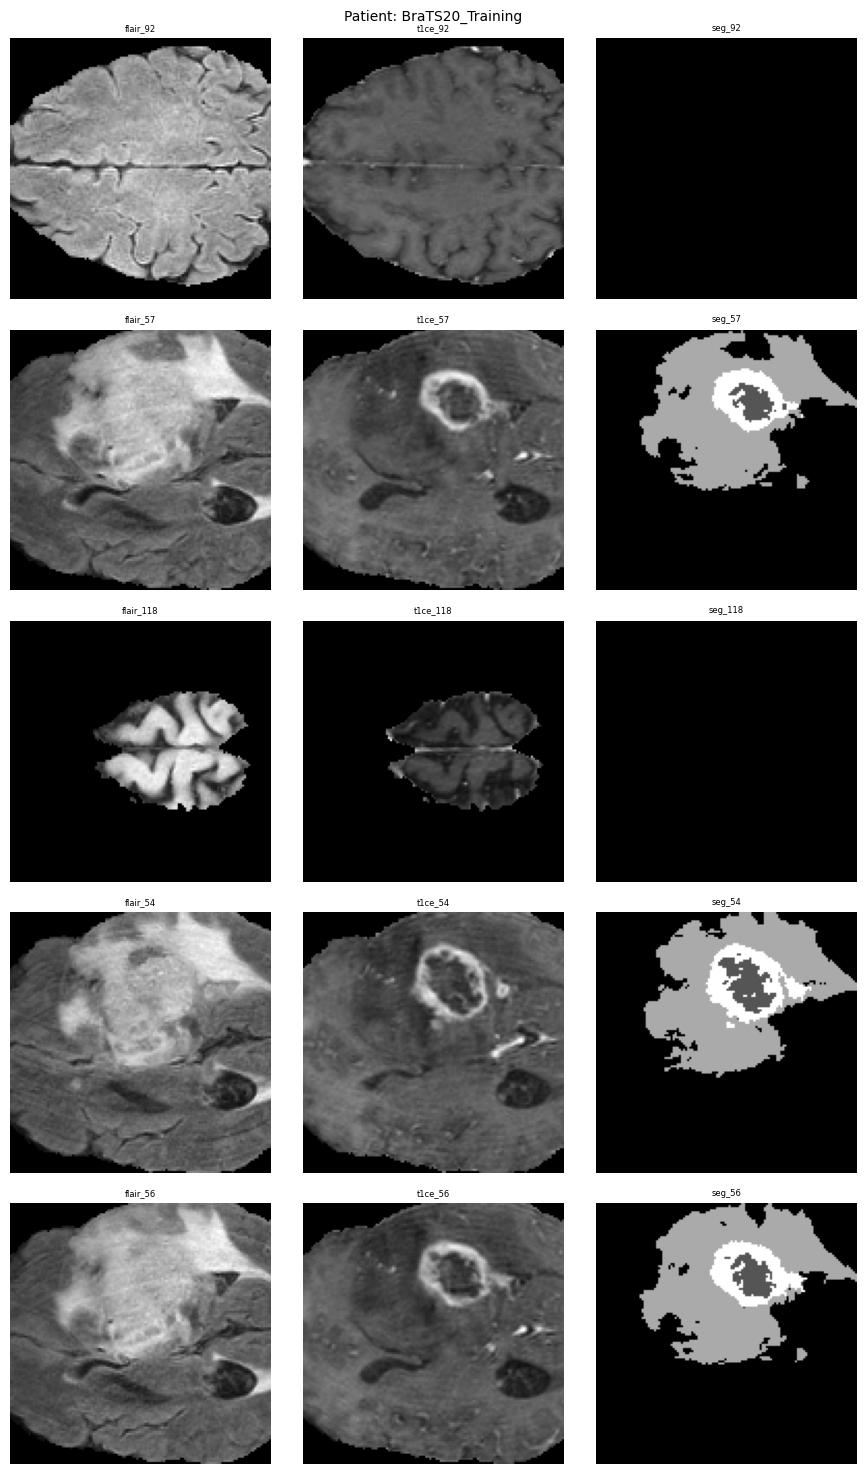

In [57]:
sanity_check_images(output_root)